**Project Goal:** To build and evaluate multiple machine learning models for classifying emails as "Spam" or "Ham" (not spam) using the provided enron emails.csv dataset.

**Step-1:** setup and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # for text processing
import re #Regular Expression

# Download necessary NLTK data (only need to do this once)
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve,auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:


try:
    df = pd.read_csv('/content/enron emails.csv', encoding='latin-1', on_bad_lines='skip')
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: 'enron emails.csv' not found. Please make sure it's uploaded.")


print("--- First 5 Rows ---")
print(df.head())

print("\n--- DataFrame Info ---")
df.info() #get the information  about the columns and data types

print("\n--- Missing Values ---")
print(df.isnull().sum()) # get the missing values

File loaded successfully!
--- First 5 Rows ---
                                             Message Category Unnamed: 2
0           Subject: christmas tree farm pictures\r       ham        NaN
1            Subject: re : rankings\r thank you .\r       ham        NaN
2  Subject: leadership development pilot\r sally ...      ham        NaN
3  Subject: key dates and impact of upcoming sap ...      ham        NaN
4  Subject: key hr issues going forward a ) year ...      ham        NaN

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33784 entries, 0 to 33783
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message     33781 non-null  object
 1   Category    33701 non-null  object
 2   Unnamed: 2  3 non-null      object
dtypes: object(3)
memory usage: 791.9+ KB

--- Missing Values ---
Message           3
Category         83
Unnamed: 2    33781
dtype: int64


**Step 2:** Data Cleaning and Preparation

In [4]:
# -- Drop Unnecessary Column and Rows with Missing Data --
df.drop(columns=['Unnamed: 2'], inplace=True) # Drop the 'Unnamed: 2' column as it's almost entirely empty
df.dropna(subset=['Message', 'Category'], inplace=True) # Drop rows where either 'Message' or 'Category' is missing

In [5]:
# -- Standardize columns --
df.rename(columns={'Message': 'text', 'Category': 'label'}, inplace=True)
df['label']=df['label'].map({'ham':0,'spam':1})

print("--- DataFrame Info After Cleaning ---")
df.info()

print("\n--- Missing Values After Cleaning (Should be all zeros) ---")
print(df.isnull().sum())

print("\n--- Final Cleaned DataFrame Head ---")
print(df.head())

--- DataFrame Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 33698 entries, 0 to 33783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33698 non-null  object
 1   label   33698 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 789.8+ KB

--- Missing Values After Cleaning (Should be all zeros) ---
text     0
label    0
dtype: int64

--- Final Cleaned DataFrame Head ---
                                                text  label
0           Subject: christmas tree farm pictures\r       0
1            Subject: re : rankings\r thank you .\r       0
2  Subject: leadership development pilot\r sally ...      0
3  Subject: key dates and impact of upcoming sap ...      0
4  Subject: key hr issues going forward a ) year ...      0


**Step-3:** Exploratory Data Analysis (EDA)
* Now that the data is clean, we can visualize it. Our main goal here is to see the distribution of spam versus ham emails to understand if our dataset is "imbalanced."

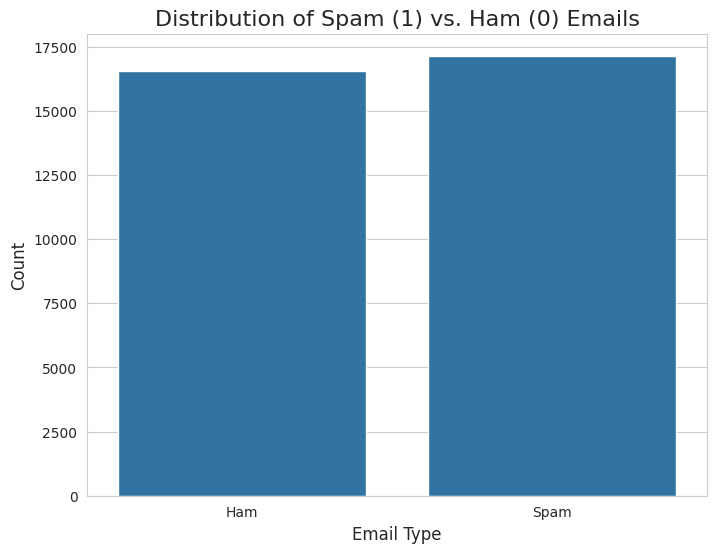

In [6]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
sns.countplot(x='label',data=df)
plt.title('Distribution of Spam (1) vs. Ham (0) Emails', fontsize=16)
plt.xlabel('Email Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])# Set custom labels for the x-axis
plt.show()


**Step 4:** Text Preprocessing
* To clean the raw email text. We will create a function that removes noise like punctuation and common "stop words") and standardizes the words to their root form. This process makes the text much easier for the models to learn from.

In [7]:
ps = PorterStemmer()

def preprocess_text(text):
    text=re.sub(r'Subject: ','',text)
    text=re.sub(r'[^a-zA-Z]',' ',text) # Keep only alphabetic characters, removing numbers and punctuation
    text=text.lower()
    words=text.split()
    #Remove common English "stop words" and apply stemming This creates a list of meaningful, stemmed words
    stemmed_words=[ps.stem(word) for word in words if word not in set(stopwords.words('english'))]
    return ' '.join(stemmed_words) # join the processed words back into a single string

df['cleaned_text']=df['text'].apply(preprocess_text)
print(df[['text', 'cleaned_text']].head()) # Display a sample to see the effect of our cleaning function

                                                text  \
0           Subject: christmas tree farm pictures\r    
1            Subject: re : rankings\r thank you .\r    
2  Subject: leadership development pilot\r sally ...   
3  Subject: key dates and impact of upcoming sap ...   
4  Subject: key hr issues going forward a ) year ...   

                                        cleaned_text  
0                          christma tree farm pictur  
1                                         rank thank  
2  leadership develop pilot salli time ask shall ...  
3  key date impact upcom sap implement next week ...  
4  key hr issu go forward year end review report ...  


**Step 5:** Feature Extraction (TF-IDF Vectorization)
* To convert our cleaned text into a numerical matrix that our models can process. We'll use the TF-IDF (Term Frequency-Inverse Document Frequency) method, which cleverly scores words based on their importance in an email relative to the entire collection of emails

In [8]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
# We will limit the features to the 3000 most frequent words to keep the model efficient and avoid noise.
tfidf = TfidfVectorizer(max_features=3000)

# Learn the vocabulary from the training data and transform it into a TF-IDF matrix
X_train_tfidf = tfidf.fit_transform(X_train)

# Use the same learned vocabulary to transform the test data
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape of the training data matrix: {X_train_tfidf.shape}")
print(f"Shape of the testing data matrix: {X_test_tfidf.shape}")

Shape of the training data matrix: (26958, 3000)
Shape of the testing data matrix: (6740, 3000)


**Step-6 :** Building and Training the Models
* This is the core machine learning step. We will train three different classification models on our TF-IDF data

In [9]:
# --- Model 1: Multinomial Naive Bayes ---
# This model is a classic choice for text classification and a great baseline.
nb_model=MultinomialNB()
nb_model.fit(X_train_tfidf,y_train)

# --- Model 2: Logistic Regression ---
# A very reliable and powerful linear model for binary classification.
lr_model=LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# --- Model 3: Support Vector Machine (SVM) ---
from sklearn.svm import SVC
# An SVM is often a top performer for classification tasks by finding the optimal boundary between classes.
svm_model=SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)


SVC(kernel='linear', probability=True, random_state=42)

**Step-7 :** Comprehensive Model Evaluation
* To rigorously evaluate and compare our three models using the test data they have never seen before. We will use the key performance metrics to decide which model is the best.


      EVALUATION: Naive Bayes
Accuracy: 0.9763

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.99      0.96      0.98      3309
    Spam (1)       0.96      0.99      0.98      3431

    accuracy                           0.98      6740
   macro avg       0.98      0.98      0.98      6740
weighted avg       0.98      0.98      0.98      6740



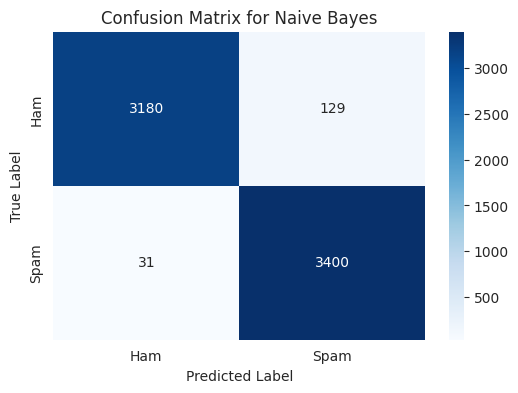


      EVALUATION: Logistic Regression
Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       1.00      0.97      0.98      3309
    Spam (1)       0.97      1.00      0.98      3431

    accuracy                           0.98      6740
   macro avg       0.98      0.98      0.98      6740
weighted avg       0.98      0.98      0.98      6740



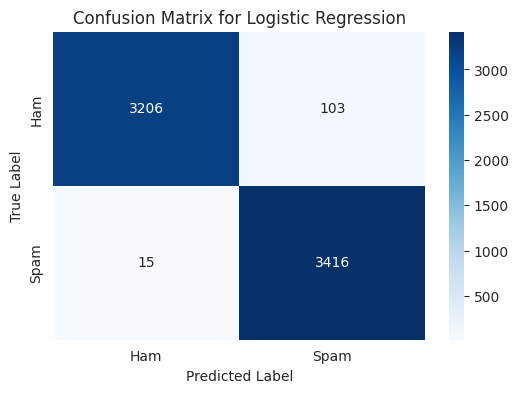


      EVALUATION: Support Vector Machine
Accuracy: 0.9846

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.99      0.97      0.98      3309
    Spam (1)       0.98      0.99      0.98      3431

    accuracy                           0.98      6740
   macro avg       0.98      0.98      0.98      6740
weighted avg       0.98      0.98      0.98      6740



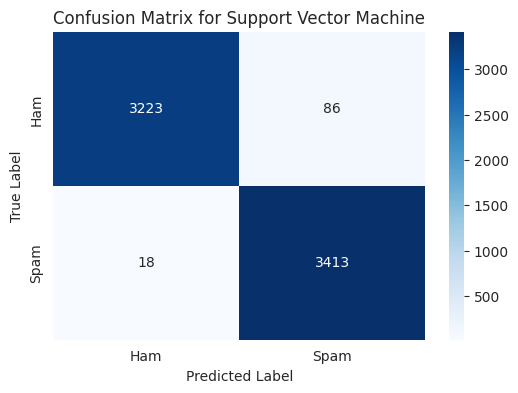

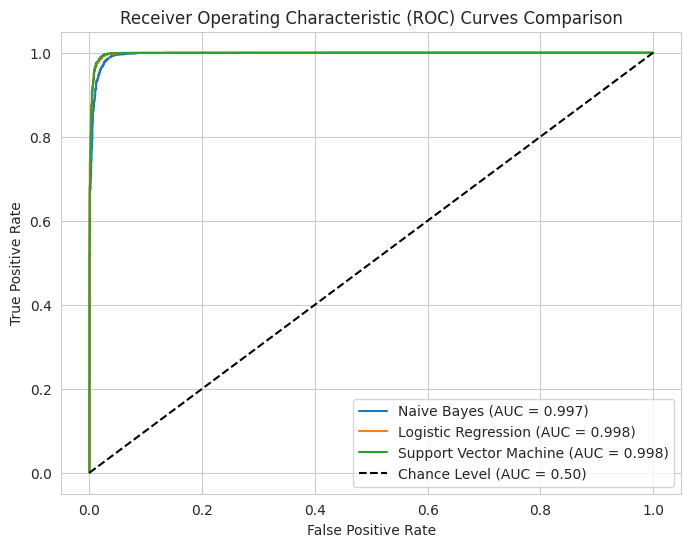

In [10]:
models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Support Vector Machine": svm_model
}

for name, model in models.items():
  y_pred=model.predict(X_test_tfidf)
  print(f"\n{'='*30}")
  print(f"      EVALUATION: {name}")
  print(f"{'='*30}")
  # 1. Accuracy Score
  print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

  # 2. Classification Report (Precision, Recall, F1-Score)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred, target_names=['Ham (0)', 'Spam (1)']))

  # 3. Confusion Matrix Visualization
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
  plt.title(f'Confusion Matrix for {name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

# --- Create a single, comparative ROC Curve Plot ---
plt.figure(figsize=(8,6))
for name, model in models.items():
   # Get prediction probabilities for the 'spam' class (the positive class)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)') # The baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Conclusion:** The Support Vector Machine (SVM) is our best-performing model. Not only does it have the highest overall accuracy, but its high Precision (0.99 for Ham, 0.98 for Spam) and Recall (0.97 for Ham, 0.99 for Spam) show that it's extremely reliable at both catching spam and avoiding false positives

**Step-8:**
* Save the Vectorizer and Best Model
* First, we need to save the two most important components to a file:

* The TF-IDF Vectorizer (tfidf): This object knows the exact vocabulary of 3,000 words learned from your training data. Any new email must be converted to numbers using this same vocabulary.

* The Trained SVM Model (svm_model): This is your best-performing model, which contains the learned patterns to distinguish spam from ham.

We'll use the pickle library to serialize and save these objects.



In [12]:
import pickle
# Create a file named 'vectorizer.pkl' to save the tfidf object in binary write mode ('wb')
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

# Create a file named 'classifier.pkl' to save the best model (svm_model)
pickle.dump(svm_model, open('classifier.pkl', 'wb'))
print("Vectorizer and Classifier have been saved to files!")

Vectorizer and Classifier have been saved to files!


**Step 9:** Build the Spam Detector Function
* Now, let's create the final prediction function. This function will load the saved files and use them to classify any new email you provide.

In [16]:
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
classifier = pickle.load(open('classifier.pkl', 'rb'))

def detect_spam(email_text):
    """
    This function takes a new email text (as a string), processes it,
    and predicts whether it is Spam or Ham.
    """
    # 1. Preprocess the new email using the SAME logic from training
    ps = PorterStemmer()
    # We create a nested function to keep the logic self-contained
    def preprocess_new_text(text):
        text = re.sub(r'Subject: ', '', text)
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        text = text.lower()
        words = text.split()
        stemmed_words = [ps.stem(word) for word in words if word not in set(stopwords.words('english'))]
        return " ".join(stemmed_words)

    cleaned_text = preprocess_new_text(email_text)
    # 2. Transform the cleaned text into a numerical vector using the loaded vectorizer
    # We wrap cleaned_text in a list because the vectorizer expects an iterable
    text_vector = vectorizer.transform([cleaned_text])

    # 3. Predict using the loaded SVM classifier
    # .predict() returns a list, so we take the first element [0]
    prediction = classifier.predict(text_vector)[0]

    # 4. Return the human-readable result
    if prediction == 1:
        return "Prediction: This email is SPAM. 🚨⚠️"
    else:
        return "Prediction: This email is HAM (Not Spam). ✅"

**Step 10:** Test our New Detector!

In [17]:
# --- Example Usage ---

# Example 1: A classic spam email
spam_email = "Subject: FREE Viagra! Exclusive offer just for you. Get a discount now, limited time only. CLICK HERE!"
print(f"Input Email: \"{spam_email}\"")
print(detect_spam(spam_email))

print("\n" + "="*50 + "\n")

# Example 2: A normal, legitimate email
ham_email = "Subject: Project Update. Hi team, please find the attached minutes from our last meeting. Let's sync up tomorrow to discuss next steps. Thanks, Jagadeesh"
print(f"Input Email: \"{ham_email}\"")
print(detect_spam(ham_email))

print("\n" + "="*50 + "\n")

# Example 3: Another potential spam email with urgent language
urgent_spam = "Subject: URGENT: Your account has been compromised! Click this link immediately to secure your account."
print(f"Input Email: \"{urgent_spam}\"")
print(detect_spam(urgent_spam))

Input Email: "Subject: FREE Viagra! Exclusive offer just for you. Get a discount now, limited time only. CLICK HERE!"
Prediction: This email is SPAM. 🚨⚠️


Input Email: "Subject: Project Update. Hi team, please find the attached minutes from our last meeting. Let's sync up tomorrow to discuss next steps. Thanks, Jagadeesh"
Prediction: This email is HAM (Not Spam). ✅


Input Email: "Subject: URGENT: Your account has been compromised! Click this link immediately to secure your account."
Prediction: This email is SPAM. 🚨⚠️
